## Implementation of 3D UNET using Pytorch

In this notebook we are going to implement 3D Unet using Pytorch to segment 3D volumes of CT scans. I am just going to use 2 volumes of data from the Liver dataset of the Medical Segmentation Decathlon (http://medicaldecathlon.com/).

For testing I am going to take in the 3rd volume for checking.

If you want to have a better understanding of 3D Unet, it is very important that you have a clear understanding of the 2D Unet. You can have a read here: https://arxiv.org/pdf/1505.04597.pdf. Also you can check out my Pytorch implementation (https://bit.ly/3IZBYzv) for better understanding. If you are confident enough, it is always better to read the paper of 3D Unet (https://arxiv.org/pdf/1606.06650.pdf) before jumping on to this Pytorch code implementation. 

Fun fuct: We are going to use **Monai**. This is the first time I am using this library. I had no idea how CT worked and prior to this I used to handle things blindly. But, after scratching through things I understood and learnt how fun Medical Imaging is. I am writing this because most probably noone will see this notebook but after some years I hope to come back and look back at me starting to like a field. More to come.

In [1]:
## Importing the necessary packages ##

import torch
import torch.nn as nn
import torchvision
import monai
from glob import glob
from torchvision.utils import make_grid
from tqdm import tqdm

from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, AddChanneld, LoadImaged, Resized, ToTensord, ScaleIntensityRanged , CenterSpatialCrop
from monai.losses import TverskyLoss, DiceLoss

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

Okay the first step is ofcourse to make our dataset.

This time we are not going to visualize a datapoint and then make our dataset. This time we gonna directly jump in and make our dataset first. (Ofcourse we need to add in the transformations!)

In [2]:
## Utility function to make the dataset ##

def make_dataset(root_dir):
    '''
    Returns the dataset instance by taking in the location of the root file location, root_dir, which contains
    the segmentation and volume subdirectories.
    '''
    
    ## Getting the filenames for the volumes and the segmentations ##
    train_vol = sorted(glob(root_dir + '/vol' + '/*.nii.gz'))
    train_seg = sorted(glob(root_dir + '/seg' + '/*.nii.gz'))
    
    assert(len(train_vol) == len(train_seg)) , 'There is a mismatch among the number of volumes and number of segmentations!'
    
    data = [{'vol' : vol_file , 'seg' : seg_file} for vol_file , seg_file in zip(train_vol , train_seg)]
    
    trans = Compose([
        LoadImaged(keys = ['vol']),
        LoadImaged(keys = ['seg'] , dtype = np.int64),
        AddChanneld(keys = ['vol' , 'seg']),
        Resized(keys = ['vol' , 'seg'] , spatial_size = [64 , 64 , 64]),
        ScaleIntensityRanged(keys = ['vol'] , a_min = -200 , a_max = 200 , b_min = 0.0 , b_max = 1.0 , clip = True),
        ToTensord(keys = ['vol' , 'seg'] , dtype = torch.float32)
    ])
    
    dataset = CacheDataset(data = data ,
                                 transform = trans,
                                 progress = True)
    
    return dataset

In [3]:
## Making our dataset by calling the utility function ##

train_dataset = make_dataset('ct_data')

## Displaying some insight about a data point ##

print('Shape of the dataset is :' , len(train_dataset))
print('Shape of the volume is :' , train_dataset[0]['vol'].shape)
print('Shape of the segmentation map is :' , train_dataset[0]['seg'].shape)
print('Maximum value of the vol is :' , torch.max(train_dataset[0]['vol']))
print('Minimum value of the vol is :' , torch.min(train_dataset[0]['vol']))
print('Segmentation classes are :' , torch.unique(train_dataset[0]['seg']))

Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.00it/s]

Shape of the dataset is : 2
Shape of the volume is : torch.Size([1, 64, 64, 64])
Shape of the segmentation map is : torch.Size([1, 64, 64, 64])
Maximum value of the vol is : tensor(1.)
Minimum value of the vol is : tensor(0.)
Segmentation classes are : tensor([0., 1., 2., 3., 4., 5.])


Now let's create a visualization utility function which would display all the slices of the ct volume.

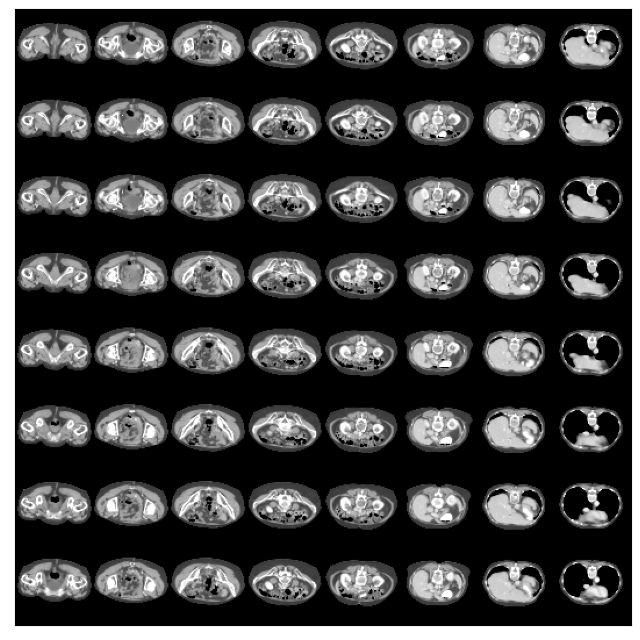

In [4]:
## Utility function for visualization ##

def display_vol(vol_tensor):
    '''
    Displays the volume tensor.
    '''
    
    vol_tensor = vol_tensor.permute(3 , 0 , 1 , 2)
    
    fig , ax = plt.subplots(figsize = (8 , 8))
    
    plt.imshow(make_grid(vol_tensor.detach().cpu() , 8).permute(2 , 1 , 0))
    
    ax.set_xticks([])
    
    ax.set_yticks([])
    
    ax.set_xticklabels([])
    
    ax.set_yticklabels([])
    
    plt.show()
    
display_vol(train_dataset[0]['vol'])

With the dataset aside, it is of the highest value to create a dataloader. So, lets do that now!!

In [5]:
## Making our dataloader ##

train_dl = DataLoader(train_dataset , 
                      batch_size = 1 , 
                      shuffle = True)

In [6]:
## Testing out the dataloader ##

for batch in train_dl:
    
    print('Volume shape :' , batch['vol'].shape)
    print('Mask shape :' , batch['seg'].shape)
    
    break

Volume shape : torch.Size([1, 1, 64, 64, 64])
Mask shape : torch.Size([1, 1, 64, 64, 64])


Now let's build our main highlight of our project, the **3D Unet Model**.

I will be following the architecture of the main paper (see figure below), with some basic tweaks to adjust the model to my training data.

![](3d_unet.png)

We are going to build the model step by step, part by part.

In [7]:
## Building the 3D Unet model ##

## Building the convolution block present in both the analysis and synthesis blocks ##

class Conv_Block(nn.Module):
    '''
    Implements the two convolution implementation along with Batch Normalization and ReLU.
    '''
    
    def __init__(self, in_channels , out_channels , block = 'analysis'):
        '''
        Parameters: 
        in_channel: number of input channel to the block.
        out_channel: number of output channels to the block.
        block: type of the block. Default: 'analysis'. (Options: 'analysis' or 'synthesis')
        '''
        super().__init__()
        self.path = None
        
        ## self.path alternates if the we are in the analysis part or in the synthesis part ##
        
        if block == 'analysis': 
            self.path = nn.Sequential(nn.Conv3d(in_channels = in_channels , 
                                            out_channels = in_channels ,
                                            kernel_size = (3 , 3 , 3) ,
                                            stride = 1,
                                            padding = 'same'),
                                  nn.BatchNorm3d(in_channels) ,
                                  nn.ReLU(),
                                  nn.Conv3d(in_channels = in_channels , 
                                            out_channels = out_channels ,
                                            kernel_size = (3 , 3 , 3) ,
                                            stride = 1,
                                            padding = 'same'),
                                  nn.BatchNorm3d(out_channels) ,
                                  nn.ReLU()) 
        else:
            self.path = self.path = nn.Sequential(nn.Conv3d(in_channels = in_channels , 
                                            out_channels = out_channels ,
                                            kernel_size = (3 , 3 , 3) ,
                                            stride = 1,
                                            padding = 'same'),
                                  nn.BatchNorm3d(out_channels) ,
                                  nn.ReLU(),
                                  nn.Conv3d(in_channels = out_channels , 
                                            out_channels = out_channels ,
                                            kernel_size = (3 , 3 , 3) ,
                                            stride = 1,
                                            padding = 'same'),
                                  nn.BatchNorm3d(out_channels) ,
                                  nn.ReLU()) 
            
    def forward(self , inp):
        '''
        Returns the output by passing the input, inp, through the conv_block.
        '''
        
        out = self.path(inp)
        
        return out

Now let's test the implementation.

In [8]:
## Testing the conv_block implementation ##

rand_int = torch.randn((1 , 64 , 64 , 64 , 64))

print('Input Shape :' , rand_int.shape)

rand_conv_block = Conv_Block(64 , 128)

rand_out = rand_conv_block(rand_int)

print('Output Shape :' , rand_out.shape)

Input Shape : torch.Size([1, 64, 64, 64, 64])
Output Shape : torch.Size([1, 128, 64, 64, 64])


Cool, so we have the basic block.

Now let's put it all together to get the entire 3d unet.

In [9]:
## Building the entire 3d unet ##

class Unet_3D(nn.Module):
    '''
    Makes the 3D Unet model.
    '''
    
    def __init__(self , in_channels = 1 , out_channels = 6 , filters = [64 , 128 , 256 , 512]):
        '''
        Parameters:
        in_channels: The input volume channel dimension.
        out_channels: The output volume channel dimension.
        '''
        
        super().__init__()
        
        ##################### Defining the Initial Block #####################
        ######################################################################
        
        self.initial_block = nn.Sequential(nn.Conv3d(in_channels = in_channels , 
                                            out_channels = 32 ,
                                            kernel_size = (3 , 3 , 3) ,
                                            stride = 1,
                                            padding = 'same'),
                                  nn.BatchNorm3d(32) ,
                                  nn.ReLU(),
                                  nn.Conv3d(in_channels = 32 , 
                                            out_channels = filters[0] ,
                                            kernel_size = (3 , 3 , 3) ,
                                            stride = 1,
                                            padding = 'same'),
                                  nn.BatchNorm3d(filters[0]) ,
                                  nn.ReLU(),
                                  ) 
        
        self.mp = nn.MaxPool3d(2, 2)
        ###################### Ending the Initial Block ######################
        ######################################################################
        
        
        self.analysis_block = nn.ModuleList([])
        self.synthesis_block = nn.ModuleList([])
        
        
        
        #################### Defining the Analysis Block #####################
        ######################################################################
        
        
        for idx , current_filter in enumerate(filters[:-2]):
            self.analysis_block.append(Conv_Block(in_channels = current_filter, 
                                                  out_channels = filters[idx + 1]))
            self.analysis_block.append(nn.MaxPool3d(2 , 2))
        
        
        
        ##################### Ending the Analysis Block ######################
        ######################################################################
        
        
        
        ## Bridge Block ##
        self.bridge_block = nn.Sequential(Conv_Block(in_channels = filters[-2], 
                                                  out_channels = filters[-1]))
        
        
        
        reversed_filters = list(reversed(filters))
        
        
        #################### Defining the Synthesis Block ####################
        ######################################################################
        
        for idx , current_filter in enumerate(reversed_filters[:-1]):
            self.synthesis_block.append(nn.ConvTranspose3d(in_channels = current_filter ,
                                                           out_channels = current_filter ,
                                                           kernel_size = 2 ,
                                                           stride = 2))
            inp_filters = reversed_filters[idx + 1] + current_filter
            self.synthesis_block.append(Conv_Block(in_channels = inp_filters,
                                                   out_channels = reversed_filters[idx + 1],
                                                   block = 'synthesis'))
        
        
        ##################### Ending the Synthesis Block #####################
        ######################################################################
        
        
        ## Final Block ##
        self.final_block = nn.Conv3d(in_channels = filters[0],
                                     out_channels = out_channels , 
                                     kernel_size = 1)

    
    def forward(self , x):
        '''
        Returns the output by passing the input, inp, through the 3D Unet.
        '''
        
        intermediate_val = []
        
        x = self.initial_block(x)
        
        intermediate_val.append(x)
        
        x = self.mp(x)
        
        for num in range(0 , len(self.analysis_block) , 2):
            x = self.analysis_block[num](x)
            
            intermediate_val.append(x)
            
            x = self.analysis_block[num + 1](x)
        
        intermediate_val = intermediate_val[::-1]
        
        x = self.bridge_block(x)
        
        for num in range(0 , len(self.synthesis_block) , 2):
            x = self.synthesis_block[num](x)
            
            shortcut_val = intermediate_val[num // 2]
            
            x = torch.cat((x , shortcut_val) , 1)
            
            x = self.synthesis_block[num + 1](x)
            
        out = self.final_block(x)
        
        return out

Now let's test the created model.

In [10]:
## Testing the created model ##

rand_int = torch.randn((1 , 1 , 64 , 64 , 64))

print('Input Shape :' , rand_int.shape)

rand_unet_3d = Unet_3D()

rand_out = rand_unet_3d(rand_int)

print('Output Shape :' , rand_out.shape)

Input Shape : torch.Size([1, 1, 64, 64, 64])
Output Shape : torch.Size([1, 6, 64, 64, 64])


And that is perfect. Our model is running perfectly and giving the perfect output.

Now with all that set, we need to finish off with just a couple of things.

1. Setting the default device. This helps in gpu implementations.
2. Creating the model instance and putting it to device.
3. Setting the Loss function. Here we are going to Tversky Loss function.
4. Setting the optimizer as Adam.
5. Finally Creating a Metric as the Dice Score which is easily calculated by taking 1 - DiceLoss.

In [11]:
## Setting the default device ##

def get_device():
    '''
    Sets the default device.
    '''
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

device = get_device()

## Creating the model instance ##

model = Unet_3D().to(device)

## Setting the loss function ##

loss_func = TverskyLoss(to_onehot_y = True , softmax = True)

## Setting the Optimizer ##

optim = torch.optim.Adam(model.parameters())

## Utility function to calculate the metrics ##

def DiceScore(pred , target):
    '''
    Calculates the Dice Score between the prediction and the target.
    '''
    dice_loss = DiceLoss(to_onehot_y = True , softmax = True , squared_pred = True)
    
    dice_val = 1 - dice_loss(pred , target).item()
    
    return dice_val

And that's it. Everything is set.

Let's get down to the main part of doing the training phase.

In [12]:
## Training the model ##

num_epochs = 50

for epoch in range(num_epochs):
    
    loop = tqdm(train_dl)
    
    for batch in loop:
        
        vol = batch['vol'].to(device)
        seg = batch['seg'].to(device)
        
        preds = model(vol)
        
        optim.zero_grad()
        
        dice_val = DiceScore(preds , seg) 
        
        loss = loss_func(preds , seg)
        
        loss.backward()
        
        optim.step()
        
        loop.set_description('Epoch : {} / {}'.format(epoch + 1 , num_epochs))
        
        loop.set_postfix(loss = loss.item() , dice = dice_val)

Epoch : 50 / 50: 100%|███████████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it, dice=0.634, loss=0.421]


Now lets save the model first.

In [13]:
## Saving the model ##

torch.save(model , 'unet_3d.pt')

Now we are going to test our model.

In [14]:
## Utility to convert the segmentation masks to a single channel mask ##

def single_channel_mask(pred):
    
    pred_prob = torch.softmax(pred , dim = 1)
    
    pred_mask = torch.argmax(pred_prob , dim = 1)
    
    return pred_mask

## Utility to convert single channel mask to RGB mask ##

def revert_back(pred_tensor):
    '''
    Changes the single channel segmentation map to rgb map.
    :param pred_tensor: A pytorch tensor.
    :return: An rgb numpy array of segmentation map.
    '''

    mapping = {
        0: [0 , 0, 0],
        1: [255, 0, 0],
        2: [0, 255, 0],
        3: [0 , 0 , 255],
        4: [255 , 204 , 255],
        5: [255 , 255 , 204]
    }

    pred_array = pred_tensor.cpu().detach().numpy()

    if len(pred_tensor.shape) == 3:
        pred_array = pred_array.squeeze(0)

    elif len(pred_tensor.shape) == 4:
        pred_array = pred_array.squeeze(0).squeeze(0)

    segmentation_map = np.zeros((pred_array.shape[0],
                                 pred_array.shape[1],
                                 3))

    for i in range(pred_array.shape[0]):
        for j in range(pred_array.shape[1]):
            map_val = pred_array[i, j]
            segmentation_map[i, j] = mapping[map_val]

    segmentation_map = segmentation_map / 255.
    return segmentation_map

In [15]:
## lets visualize some slices of the original and predicted segmentation ##

def visualize_seg_slice(pred , target):
    
    idx = int(np.random.randint(low = 0 , high = pred.shape[-1] , size = 1))
    
    #idx = 32
    
    pred = pred.squeeze(0)
    
    target = target.squeeze(0)
    
    pred_slice = pred[ : , : , idx]
    
    target_slice = target[ : , : , idx]
    
    pred_slice = revert_back(pred_slice)
    
    target_slice = revert_back(target_slice)
    
    #plt.title('Idx is :' + str(idx))
    
    plt.subplot(2 , 1 , 1)
    
    plt.imshow(pred_slice)
    
    plt.subplot(2 , 1 , 2)
    
    plt.imshow(target_slice)
    
    plt.show()

  0%|                                                                                | 0/1 [00:00<?, ?it/s, dice=0.531]

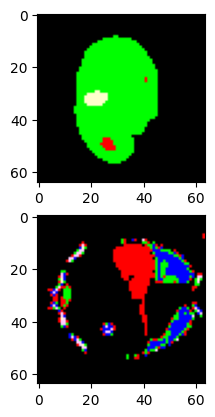

100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s, dice=0.531]


In [16]:
## creating test dataset ##

test_dataset = make_dataset(root_dir = 'test_ct_data')

## Creating test dataloader ##

test_dl = DataLoader(test_dataset , batch_size = len(test_dataset))

## Checking the Dice Score ##

loop = tqdm(test_dl)
    
for batch in loop:
    
    model.eval()
    
    vol = batch['vol'].to(device)
    seg = batch['seg'].to(device)
        
    preds = model(vol)
    
    dice_val = DiceScore(preds , seg)
        
    loop.set_postfix(dice = dice_val)
    
    pred_1c = single_channel_mask(preds)

    visualize_seg_slice(pred_1c , seg)

Okay so our model predicted not so well. And that was expected. We trained with only 2 volumes :P . Anyways this gives a good starting point to our movement towards Medical Imaging.

Cheers :)